In [ ]:
# %load reload_ext
# %reload_ext 2

In [2]:
# %matplotlib inline
import matplotlib.pyplot as plt
import cv2
from kitti_object import *


In [3]:
from xvfbwrapper import Xvfb
vdisplay = Xvfb(width=1920, height=1080)
vdisplay.start()
from mayavi import mlab
mlab.init_notebook('ipy') # do not use 'x3d' backend which leads to color missing

/root/miniconda3/envs/kitti_vis/lib/python3.8/site-packages/traits/etsconfig/etsconfig.py:412: UserWarning: Environment variable "HOME" not set, setting home directory to /tmp
  warn(


Notebook initialized with ipy backend.


In [4]:
# 
from glob import glob
import os
paths = glob('../waymo_kitti_converter/data/waymo/training/label_2/*.txt')
ids = [int(os.path.basename(path).split('.')[0]) for path in paths]
len(ids)

9247

In [5]:
ids = list(sorted(ids))
data_idx = ids[200]#list(sorted(ids[0]))
data_idx

1078

In [6]:
# dataset = kitti_object('../data/kitti/psedo/', 'training')
dataset = kitti_object('../waymo_kitti_converter/data/waymo/', 'training', img_ext='jpg', cam_id=0)
dataset.num_samples = 100000

objects = dataset.get_label_objects(data_idx)
pc_velo = dataset.get_lidar(data_idx)
calib = dataset.get_calibration(data_idx)
img = dataset.get_image(data_idx)
img_height, img_width, _ = img.shape

# fig_3d = mlab.figure(bgcolor=(0, 0, 0), size=(800, 450))
# show_lidar_with_depth(pc_velo, objects, calib, fig_3d, True, img_width, img_height)

../waymo_kitti_converter/data/waymo/ training
../waymo_kitti_converter/data/waymo/training/velodyne/0001078.bin


In [7]:
import matplotlib.pyplot as plt

def show_lidar_on_image(pc_velo, img, calib, img_width, img_height):
    """ Project LiDAR points to image """
    img =  np.copy(img)
    imgfov_pc_velo, pts_2d, fov_inds = get_lidar_in_image_fov(
        pc_velo, calib, 0, 0, img_width, img_height, True
    )
    imgfov_pts_2d = pts_2d[fov_inds, :]
    imgfov_pc_rect = calib.project_velo_to_rect(imgfov_pc_velo)

    max_num_color = 640.0 / imgfov_pc_rect[:,2].min()
    cmap = plt.cm.get_cmap("hsv", max_num_color)
    cmap = np.array([cmap(i) for i in range(512)])[:, :3] * max_num_color

    for i in range(imgfov_pts_2d.shape[0]):
        depth = imgfov_pc_rect[i, 2]
        color = cmap[int(640.0 / depth), :]
        cv2.circle(
            img,
            (int(np.round(imgfov_pts_2d[i, 0])), int(np.round(imgfov_pts_2d[i, 1]))),
            2,
            color=tuple(color),
            thickness=-1,
        )
    cv2.imshow("projection", img)
    return img



In [8]:
# img_lidar = show_lidar_on_image(pc_velo[:, :3], img, calib, img_width, img_height)
# img_lidar = cv2.cvtColor(img_lidar, cv2.COLOR_BGR2RGB)

# fig_lidar = plt.figure(figsize=(22,22))
# ax_lidar = fig_lidar.subplots()
# img_img_lidar = np.concatenate([img, img_lidar], 0)
# ax_lidar.imshow(img_img_lidar)
# plt.show()

In [9]:
def show_image_with_boxes(img, objects, calib, show3d=True, depth=None):
    """ Show image with 2D bounding boxes """
    img1 = np.copy(img)  # for 2d bbox
    img2 = np.copy(img)  # for 3d bbox
    #img3 = np.copy(img)  # for 3d bbox
    #TODO: change the color of boxes
    for obj in objects:
        if obj.type == "DontCare":
            continue
        if obj.type == "Car":
            cv2.rectangle(
            img1,
            (int(obj.xmin), int(obj.ymin)),
            (int(obj.xmax), int(obj.ymax)),
            (0, 255, 0),
            2,
        )
        if obj.type == "Pedestrian":
            cv2.rectangle(
            img1,
            (int(obj.xmin), int(obj.ymin)),
            (int(obj.xmax), int(obj.ymax)),
            (255, 255, 0),
            2,
        )
        if obj.type == "Cyclist":
            cv2.rectangle(
            img1,
            (int(obj.xmin), int(obj.ymin)),
            (int(obj.xmax), int(obj.ymax)),
            (0, 255, 255),
            2,
        )
        box3d_pts_2d, _ = utils.compute_box_3d(obj, calib.P)
#         if obj.type == "Car":
#         import ipdb; ipdb.set_trace()
        if box3d_pts_2d is not None:
            img2 = utils.draw_projected_box3d(img2, box3d_pts_2d, color=(0, 255, 0))
#         except:
#             import ipdb; ipdb.set_trace()
#         elif obj.type == "Pedestrian":
#             img2 = utils.draw_projected_box3d(img2, box3d_pts_2d, color=(255, 255, 0))
#         elif obj.type == "Cyclist":
#             img2 = utils.draw_projected_box3d(img2, box3d_pts_2d, color=(0, 255, 255))


        # project
        # box3d_pts_3d_velo = calib.project_rect_to_velo(box3d_pts_3d)
        # box3d_pts_32d = utils.box3d_to_rgb_box00(box3d_pts_3d_velo)
        # box3d_pts_32d = calib.project_velo_to_image(box3d_pts_3d_velo)
        # img3 = utils.draw_projected_box3d(img3, box3d_pts_32d)
    # print("img1:", img1.shape)
    cv2.imshow("2dbox", img1)
    # print("img3:",img3.shape)
    # Image.fromarray(img3).show()
    show3d = True
    if show3d:
        # print("img2:",img2.shape)
        cv2.imshow("3dbox", img2)
    if depth is not None:
        cv2.imshow("depth", depth)
    
    return img1, img2

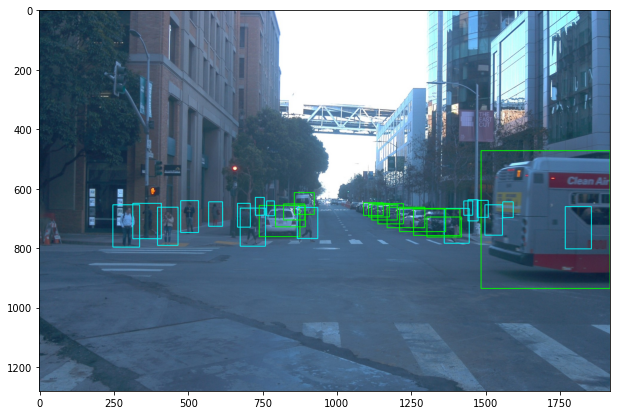

In [10]:
img_bbox2d, img_bbox3d = show_image_with_boxes(img, objects, calib)
img_bbox2d = cv2.cvtColor(img_bbox2d, cv2.COLOR_BGR2RGB)

fig_bbox2d = plt.figure(figsize=(14, 7))
ax_bbox2d = fig_bbox2d.subplots()
ax_bbox2d.imshow(img_bbox2d)
plt.show()

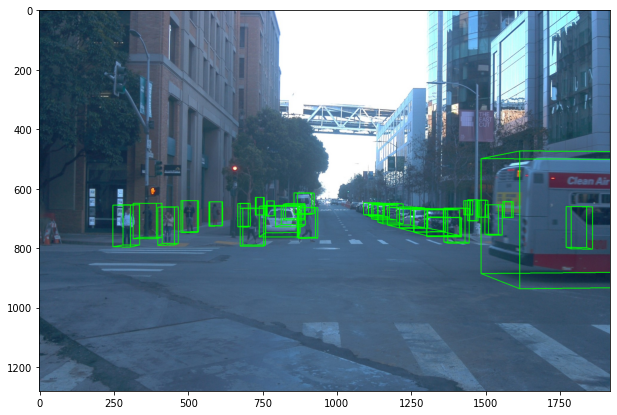

In [11]:
img_bbox3d = cv2.cvtColor(img_bbox3d, cv2.COLOR_BGR2RGB)

fig_bbox3d = plt.figure(figsize=(14, 7))
ax_bbox3d = fig_bbox3d.subplots()
ax_bbox3d.imshow(img_bbox3d)
plt.show()

In [12]:
# pc_velo.

In [20]:
def show_lidar_topview_with_boxes(pc_velo, objects, calib, objects_pred=None):
    """ top_view image"""
    # print('pc_velo shape: ',pc_velo.shape)
    top_view = utils.lidar_to_top(pc_velo)
#     top_view = top_view/top_view.mean()

    top_image = utils.draw_top_image(top_view)
    top_image = top_image*100/top_image.mean()
    print("top_image:", top_image.shape)
#     import ipdb;ipdb.set_trace()
    def bbox3d(obj):
        _, box3d_pts_3d = utils.compute_box_3d(obj, calib.P)
        box3d_pts_3d_velo = calib.project_rect_to_velo(box3d_pts_3d)
        return box3d_pts_3d_velo

    boxes3d = [bbox3d(obj) for obj in objects if obj.type != "DontCare"]
    gt = np.array(boxes3d)
    # print("box2d BV:",boxes3d)
    lines = [obj.type for obj in objects if obj.type != "DontCare"]
    top_image = utils.draw_box3d_on_top(
        top_image, gt, text_lables=lines, scores=None, thickness=1, is_gt=True
    )
    # pred
    if objects_pred is not None:
        boxes3d = [bbox3d(obj) for obj in objects_pred if obj.type != "DontCare"]
        gt = np.array(boxes3d)
        lines = [obj.type for obj in objects_pred if obj.type != "DontCare"]
        top_image = utils.draw_box3d_on_top(
            top_image, gt, text_lables=lines, scores=None, thickness=1, is_gt=False
        )

    cv2.imshow("top_image", top_image)
    return top_image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


top_image: (500, 300, 3)


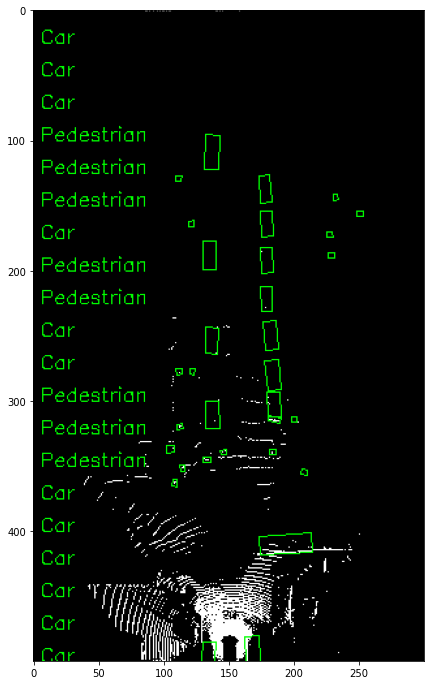

In [21]:
img_bev = show_lidar_topview_with_boxes(pc_velo, objects, calib)

fig_bev = plt.figure(figsize=(7, 14))
ax_bev = fig_bev.subplots()
ax_bev.imshow(img_bev)
plt.show()